In [237]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [238]:
file_path = '../elidata/Merged_Ni_lessthan15km.csv'

df = pd.read_csv(file_path, index_col=0)
df.head(3)

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
0,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46661,"(-17.34893, 128.022095)",S0001442,-17.234642,128.032146,12.693593881734987 km
1,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46662,"(-17.31078, 128.023499)",S0002890,-17.234642,128.032146,8.476376684524638 km
2,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46663,"(-17.3526, 128.027695)",S0019720,-17.234642,128.032146,13.063277176872425 km


In [239]:
df.shape

(150625, 19)

In [240]:
df[df['Co'] == df['Co'].max()]

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
15478,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73190,"(-26.107121, 127.696899)",S0019102,-26.061367,127.580028,12.744010894761297 km
15479,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73191,"(-26.107121, 127.696899)",S0224398,-26.061367,127.580028,12.744010894761297 km


In [241]:
df_unique = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'lat', 'long', 
                     'minedex_coords', 'minedex_site',
                    'distance'])

df_unique = df_unique.drop_duplicates()

In [242]:
print(f"Amount of Duplicate rows: {df.shape[0] - df_unique.shape[0]}")

Amount of Duplicate rows: 127392


In [243]:
df_unique.shape

(23233, 12)

### WAMEX data

 ·      Cobalt associated with nickel (and copper) in so-called orthomagmatic (igneous) mafic to ultramafic volcanic (komatiite)-hosted and intrusion-hosted deposits
 
 
 Cobalt is a chemical element with the symbol Co and atomic number 27. Like nickel, cobalt is found in the Earth's crust only in a chemically combined form, save for small deposits found in alloys of natural meteoric iron. The free element, produced by reductive smelting, is a hard, lustrous, silver-gray metal. Wikipedia
Symbol: Co <br>
Electron configuration: [Ar] 3d74s2 <br>
Atomic number: 27 <br>
Atomic mass: 58.933195 u <br>
Melting point: 1,495 °C <br>
Discovered: 1735 <br>
Discoverer: Georg Brandt <br>

### Nickel, Copper and Cobalt Interactions

In [244]:
# most common pair in MINEDEX data.
abdundant_minerals = ['Copper', 'Nickel', 'Iron', 'Gold', 'Silver'] #'Sulfur', 'Palladium','Platinum',
critical_mineral = ['Cobalt']

full_to_atomic = {
    "Copper": "Cu",
    "Cobalt": "Co",
    "Nickel": "Ni",
    "Iron": "Fe",
    "Sulfur": "S",
    "Palladium": "Pd",
    "Platinum": "Pt",
    "Gold": "Au",
    "Silver": "Ag"
}


In [245]:
def get_clean_mineral_col(df):
    new_cols = []
    for col in df.columns: 
        if "ppm" in col:
            new_cols.append(col.split('_')[0])
        else:
            new_cols.append(col)
            
    return new_cols

df_unique.columns = get_clean_mineral_col(df_unique)

In [246]:
df_unique.head(2)

,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,wamex_lat,wamex_lon
0,56.0,420.0,9.0,14.0,0.010,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146
5,31.0,195.0,6.0,10.0,0.007,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146


In [247]:
minerals = abdundant_minerals + critical_mineral

minerals_atomic = [full_to_atomic[mineral] for mineral in minerals]
minerals_atomic

['Cu', 'Ni', 'Fe', 'Au', 'Ag', 'Co']

In [248]:
input_cols = ['wamex_lat', 'wamex_lon'] + minerals_atomic

In [249]:
df_inputs = df_unique[input_cols]
df_inputs.head(2)

,wamex_lat,wamex_lon,Cu,Ni,Fe,Au,Ag,Co
0,-17.234642,128.032146,420.0,56.0,NaN,0.010,NaN,9.0
5,-17.234642,128.032146,195.0,31.0,NaN,0.007,NaN,6.0


In [250]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
    
def abs_halve_neg_val(val):
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

def clean_assays(df):
    df = df.applymap(replace_neg9999)
    df = df.applymap(abs_halve_neg_val)

    # all 9999 -> 0 values are removed
    indexs_0 = df[df.values == 0].index
    df = df.drop(index=indexs_0)
    
    return df

def abundant_ratio(row, abundant_mineral):
    return row / row[abundant_mineral]


In [251]:
df_minerals = df_inputs.drop(columns=['wamex_lat', 'wamex_lon'])

df_inputs.loc[:, df_minerals.columns] = clean_assays(df_inputs.loc[:,df_minerals.columns])
df_inputs.shape

C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


(23233, 8)

## `drop_na`

In [256]:
df_inputs = df_inputs.dropna()
df_inputs.shape

(8875, 8)

<AxesSubplot:ylabel='Frequency'>

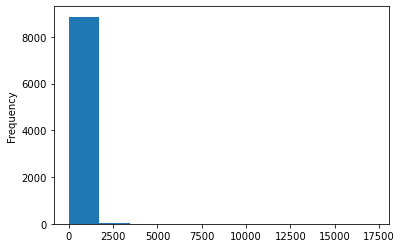

In [257]:
df_inputs['Co'].plot(kind='hist')

### LARGE AF Colbalt deposits

In [258]:
df_inputs[df_inputs['Co'] > 10000]

,wamex_lat,wamex_lon,Cu,Ni,Fe,Au,Ag,Co
52865,-32.096211,121.651299,46.0,10782.0,12120.0,0.0025,0.16,17180.0


### Apply Ratio Transform

In [259]:
df_inputs.loc[:, df_minerals.columns] = df_inputs.loc[:, df_minerals.columns].apply(
                                                            abundant_ratio, abundant_mineral='Ni',
                                                            axis=1)

In [260]:
df_inputs['Co'].describe()

count    8875.000000
mean        0.517796
std         2.690492
min         0.000684
25%         0.095844
50%         0.235294
75%         0.363636
max       118.833333
Name: Co, dtype: float64

### Log Transform

<AxesSubplot:ylabel='Frequency'>

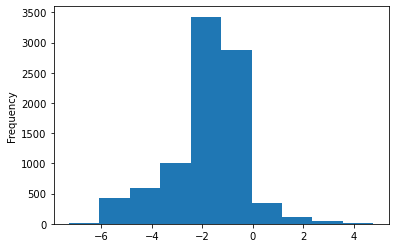

In [263]:
np.log(df_inputs[df_inputs['Co'] < 5000]['Co']).plot(kind='hist')

In [264]:
df_inputs.loc[:, df_minerals.columns] = df_inputs.loc[:,df_minerals.columns].apply(np.log, axis=1)

In [265]:
df_inputs

,wamex_lat,wamex_lon,Cu,Ni,Fe,Au,Ag,Co
106,-17.742535,127.903385,-1.030718,0.0,3.297989,-12.112860,-8.200837,-1.046222
109,-17.737059,127.903390,-1.162504,0.0,3.120324,-12.417953,-8.505930,-1.383063
112,-17.737963,127.903422,-1.081499,0.0,3.287720,-12.098487,-8.186464,-1.501853
115,-17.734329,127.903425,-1.503565,0.0,3.813017,-11.488633,-7.576610,-0.774215
193,-30.486709,121.992519,0.627550,0.0,5.198234,-9.259131,-4.836282,-1.147402
...,...,...,...,...,...,...,...,...
134162,-27.697064,120.657557,0.693147,0.0,5.023881,-9.210340,-4.605170,-1.203973
135965,-27.699810,120.655572,1.070441,0.0,3.735684,-11.695247,-8.476371,-4.094345
136098,-27.700048,120.655769,1.034074,0.0,4.106767,-11.289782,-8.070906,-3.688879
143779,-27.699929,120.655701,0.223144,0.0,3.729701,-12.388394,-7.783224,-3.534729


### Independent Variables

In [266]:
from sklearn.preprocessing import StandardScaler

## Plotting First 100 Observations

<AxesSubplot:>

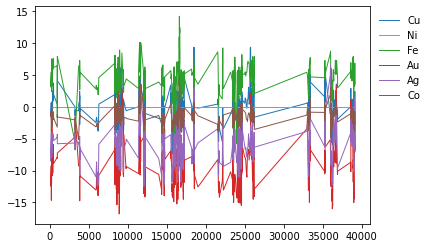

In [304]:
df_inputs[minerals_atomic][:1000].plot()

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrolite.plot import pyroplot
from pyrolite.plot.density import density
from pyrolite.comp.codata import close

### Plot before ratio transform (else Ni is 1)

In [276]:
# plotting_minerals = ['Ni', 'Co', 'Ni']

# df_plot = df_inputs[plotting_minerals]

In [277]:
# fig, ax = plt.subplots(
#     1,
#     3,
#     sharex=True,
#     sharey=True,
#     figsize=(15, 5),
#     subplot_kw=dict(projection="ternary"),
# )
# df_plot.pyroplot.scatter(ax=ax[0], alpha=0.05, c="k")
# for a, mode in zip(ax[1:], ["hist", "density"]):
#     df_plot.pyroplot.density(ax=a, mode=mode)
#     a.set_title("Mode: {}".format(mode), y=1.2)

# plt.tight_layout()
# plt.show()

### Drop `Ni`

In [346]:
df_inputs = df_inputs.drop(columns=['Ni'])

### Split Indepdent from dependents

In [347]:
y = df_inputs['Co']
X = df_inputs.drop(columns=['Co'])

In [349]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()

lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

from sklearn.metrics import mean_squared_error

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 0.684159355641087
Test MSE: 0.7213658049947134


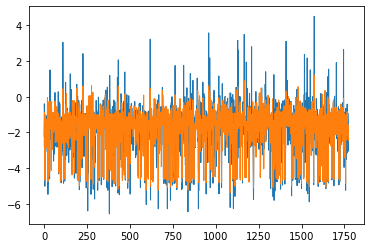

In [350]:
plt.plot(range(0, len(test_preds)), y_test, test_preds)

In [351]:
pd.Series(X_train.columns, lr.coef_).sort_values(ascending=False)

-0.119677    wamex_lon
-0.022340    wamex_lat
 0.248925           Fe
 0.226367           Cu
-0.058686           Au
-0.006738           Ag
dtype: object

#### Random Forrest

In [354]:
rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 0.04254957071518172
Test MSE: 0.3332692413797282


<AxesSubplot:ylabel='Frequency'>

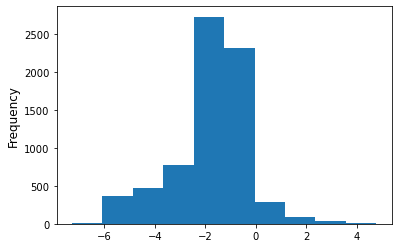

In [355]:
y_train.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

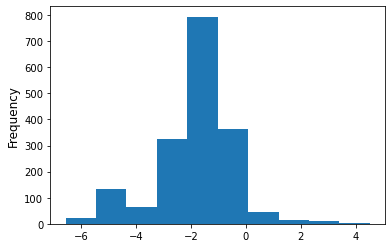

In [356]:
y_test.plot(kind='hist')

In [357]:
pd.Series(X_train.columns,rf.feature_importances_).sort_values(ascending=False)

0.088850    wamex_lon
0.053745    wamex_lat
0.674328           Fe
0.074442           Cu
0.077440           Au
0.031196           Ag
dtype: object

### Model Interpretation

In [358]:
import shap

In [359]:
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.to_numpy() 

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


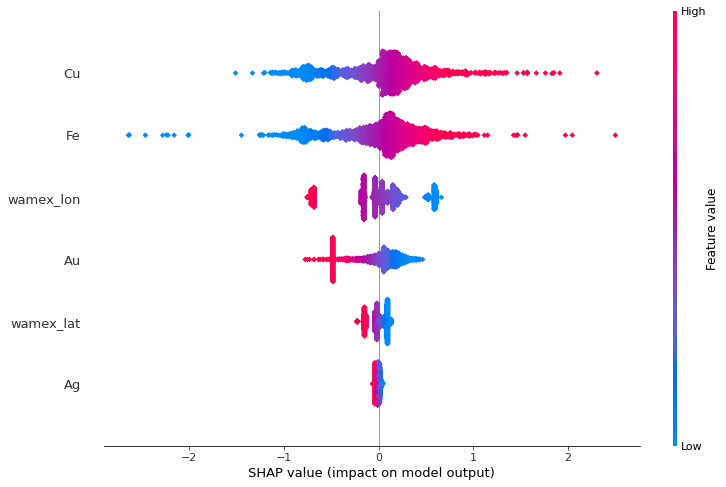

In [360]:
shap.summary_plot(shap_values, X_test_array, 
                  feature_names=X_test.columns,
                 plot_size=(12,8))

### `force_plot`

In [366]:
# load javascript plugin
shap.initjs()

In [367]:
X_test.iloc[1]

wamex_lat    -31.374817
wamex_lon    121.428821
Cu             0.116260
Fe             4.066565
Au            -7.732479
Ag            -5.676754
Name: 106287, dtype: float64

In [368]:
ind = 1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=X_test.columns
)


In [369]:
ind = 2
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=X_test.columns
)


In [370]:
ind = 100
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=X_test.columns
)


### Jobs to do:

- Investigate Overfitting of RF, what is causing it.
- Try another ML model.
- Compare Model performances with entire minerals dataset (not just the subset).
- Compare different mineral comibi